In [ ]:
!pip install qiskit==0.7.1
!pip install qiskit_aer==0.1.1
!pip install IBMQuantumExperience

# Implementation of Quantum Walks on graph  for IBM Q
This notebook is based on the paper of  B L Douglas and J B Wang, "Efficient quantum circuit implementation of quantum walks", arXiv:0706.0304 [quant-ph].

## Contributors
Jordan Kemp(University of Chicago), Shin Nishio(Keio University), Ryosuke Satoh(Keio University), Desiree Vogt-Lee(University of Queensland), and Tanisha Bassan(The  Knowledge Society)

## Introduction: challenges in implementing quantum walk

There are so  many types of quantum walks. A walker can walk on n-dimensional space or any limited graphs. First we talk about the concept and dynamics of Quantum and Classical random walk. After that we show the implementation of Quantum Walk on cycle graph.

## Random walk 
A random walk is a dynamical path with a randomly evolving time system. The figure below shows a simple type of random walk. 

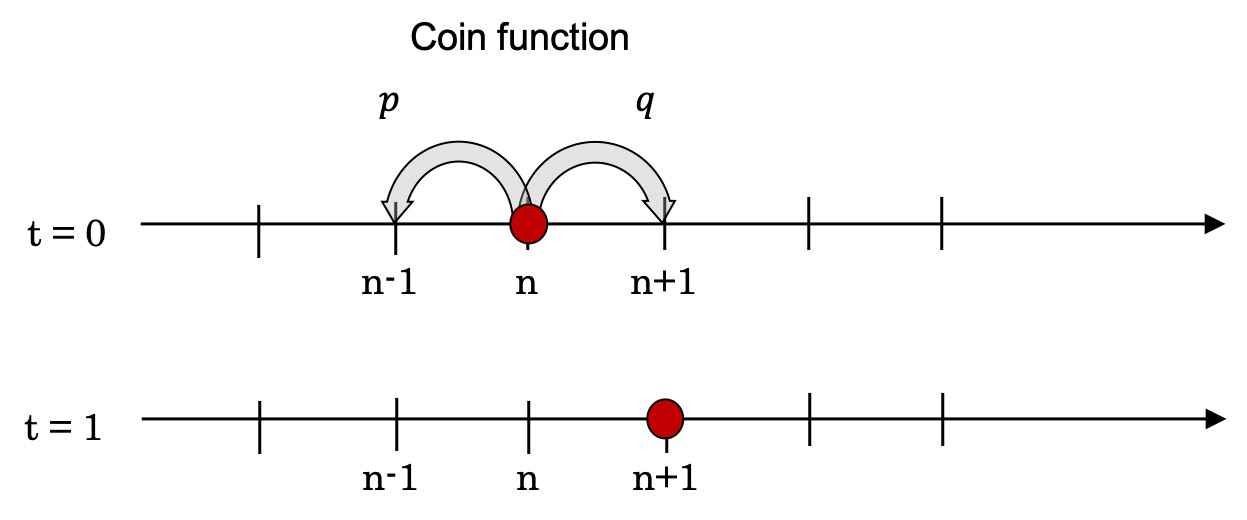

In [2]:
import os
import os.path
from IPython.display import display
from PIL import Image
path = "./random_walk.jpg"
display(Image.open(path))

The dynamics can be regarded as a simple algorithm as shown.
1. There is a $n$-dimension(in this case, one for simple) space and a walker start at the point $x=0$
2. take a step either forward (toward $+x$) or backward(toward $-x$) 
in 2., the choice is to be made randomly(ex: coin-flip). We call this "Coin Operator". 

In this system, $p+q = 1$

## Quantum walk 
Quantum walk is "quantum version" of random walk. This means the function can be Unitary gate($U(2)$) which is non-random and reversible. 

$p+q = U ∈ U(2)$. 

In these experiments, we use a Hadamard gate for executing the coin function as since it puts our qubits in a state of superposition which is abel to simulate the coin based probability:
$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

There are continuous and discrete quantum walks, in our experiment we use the discrete framework. In the discrete walks, unitary operations are made of coin and shift operators U = SC which work in a state space.
An arbitrary undirected graph $G(V,E)$ where $V = {v_1, v_2, ..v_n}$ as nodes on the graph and $E = {(v_x, v_y) , ( v_i, v_j) …}$ as edges that combine different nodes together.
The quantum walk extends into a position space where each node $v_i$ with a certain valency $d_i$ is split into $d_i$ subnodes. The shifting operator then acts as $S (v_i, a_i) = (v_j, a_j)$ and coin operator are unitary gates which combine the probability amplitudes with individual subnodes under each node.
A unitary of $v_i$ with valency $d_i$ can be represented as $(d_i \times d_i)$. The total states of system is defined by the Hilbert space $$H = H_c + H_p$$, respectively coin Hilbert space and position Hilbert space. 


## Coin function
The first step in a quantum random walk is the coin operator. The operation works by an arbitrary unitary transformation in the coin space which creates a rotation similar to “coin-flip” in random walk. This is mainly the hadamard gate which models the balanced unitary coin. 
$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

The coin register will continue interfering with it’s position state until measured after all intermediate steps. The results are very different from random walks, it doesn’t converge to a Gaussian distribution but to evolves into an asymmetric probability distribution. This happens because the Hadamard coin operator treats each basis vectors |↑> and |↓>  differently. The rightwards path interferes more destructively as it’s multiplied but -1, the leftwards path is constructive interference: the system tends to take steps towards the left. To reach symmetric results, both base vectors will start in superposition states of both |↑> and |↓>. Another way to reach symmetry is use a different coin operator which doesn’t bias the coin towards a certain base vector. 
$$Y=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & i \\ i & 1\\ \end{array}}\right]$$


## Quantum walk on cycle graph
Our experiment is conducting a quantum random walk on circular graph which is efficiently and simply implemented on the quantum circuit. The graph has 8 nodes with 2 attached edges which act as the subnodes on the circuit. 


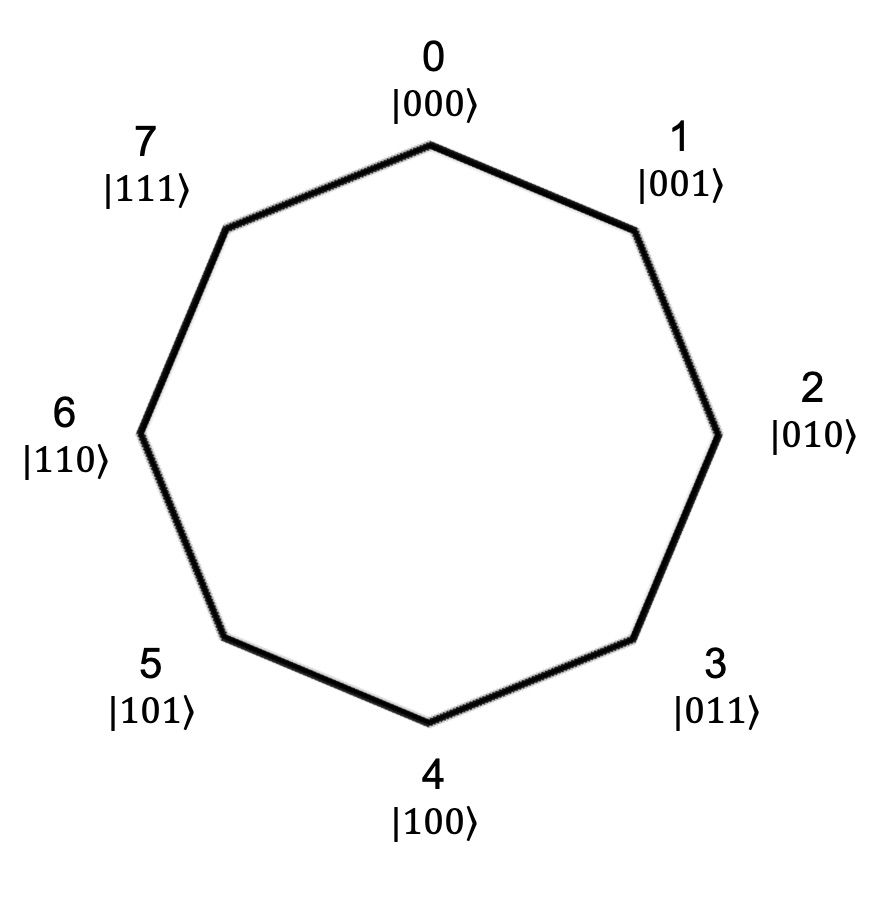

In [2]:
path_8 = "./8_white.jpg"
display(Image.open(path_8))

The operations propagate systemically around the graph as each node is a seperate bit-string value in lexicographic order. For 2n graph, n qubits required to encode problem and 1 ancilla qubit for subnode(coin). 

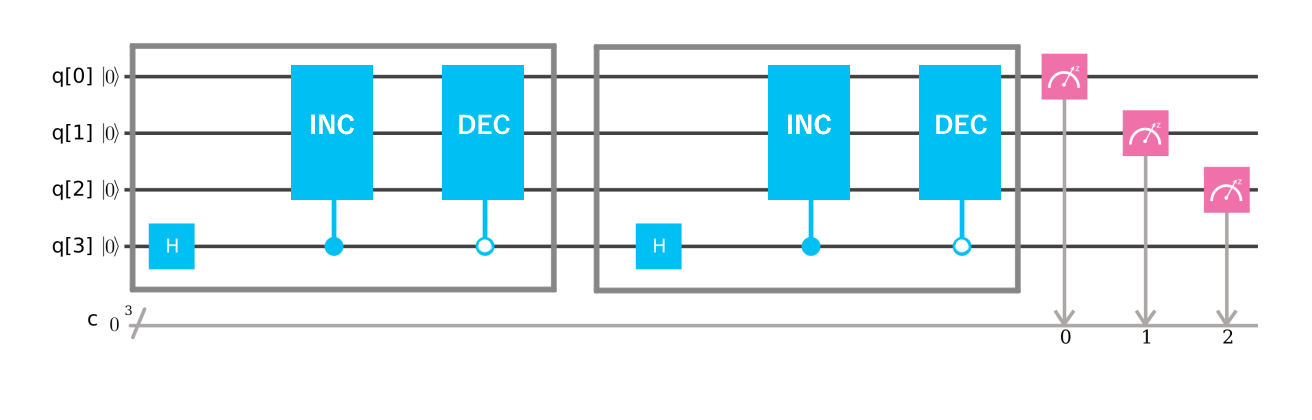

In [3]:
path_circ = "./whole_circuit.jpg"
display(Image.open(path_circ))

This circuits shows whole process(for 2 flip) of Quantum Walk on cycle graph with $2^3$nodes. 
The gray square frame is a set of Coin operator and shift operators. 
In this circuit, q[0] to q[2] represents the state (position) of quantum walker, and q[3] represents the Coin Operator.

In this style, a programmer can insert initial position of walker as 3-qubits state. For example, if the input is $110$, the position is $6$.

The coin operator decide whether walker go Clockwise or Counterclockwise.

INC is gates that increments the state of walker which is equal to Clockwise rotation in the cycle graph. 
DEC is gates that decrements the state of walker which is equal to Counterclockwise rotation in cycle graph.

After repeating of the coin operator and the shift operator, we measure the qubits other than the coin qubit, and it is possible to know the position of the walker.

## $n$-qubit Toffoli

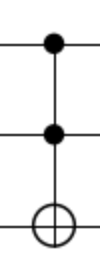

In [4]:
path_toffoli = "./toffoli.png"
display(Image.open(path_toffoli))

Toffoli gate is CCNOT(CCX) gate.
By using Toffoli, X gates executed on Q2 if Q0 and Q1 is 1.
In quantum walk implementation, we need more connection for expanding quantum walk implementation.
For example, CCX can be written as below by using only available gate set of IBMQ devices.

Thus, more than 4 qubits, we can implement many qubits of CX gate ("C$N$X gate") with this way.
Reference is shown [here]("https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.3457").


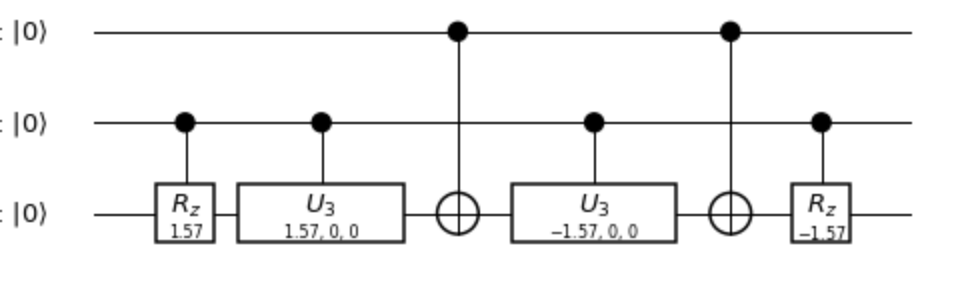

In [5]:
path_imp = "./implement_toffoli.png"
display(Image.open(path_imp))

C$N$X can be represented using C($N-1$)X as shown.

In [13]:
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu3(np.pi/2, 0, 0, qubits[-2],qubits[-1])
        
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #B matrix (cry again, but opposite angle)
        qc.cu3(-np.pi/2, 0, 0, qubits[-2], qubits[-1])
        
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

Decide the number of qubits $n$ to represent the walker's state (the whole circuits requires $n+1$ qubits).

In [14]:
import numpy as np
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city

n=3

In [15]:
IBMQ.load_accounts()
#IBMQ.enable_account("53a94ea70a24c85cfac5f5e87e369d813f5efff70fed9c973b2b3637be5b2e0378da1921b5bbd786574e74d44dd8a64dda3095dbbda528b414c1b567476a87b2")
IBMQ.backends()

/Users/parton/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:251: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

We need to perform the increment gate and decrement gate in order for the shift operator to walk.
Both of them including the C$N$X gates and change the position of the walker based on the coin operator.

In [1]:
#IN/DECREMENT GATES FOR N=3

def increment_gate(qwc, q, subnode):
  
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  cnx(qwc, subnode[0], q[2], q[1])
  cnx(qwc, subnode[0], q[2])
  qwc.barrier()
  return qwc

def decrement_gate(qwc, q, subnode):
  
  qwc.x(subnode[0])
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1])
  qwc.x(q[2])
  cnx(qwc, subnode[0], q[2])
  qwc.x(subnode[0])
  return qwc
  
def ibmsim(circ):
  ibmqBE = IBMQ.get_backend('ibmq_qasm_simulator')
  return execute(circ,ibmqBE, shots=1000).result().get_counts(circ)  

Repeat coin operator and shift operator for any steps(in this case 15).

In [22]:
qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)


def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc,qnodes,qsubnodes[0])
        qwc.measure(qnodes, cnodes)

    return qwc

step = 15
qwc = runQWC(qwc, step)
result = ibmsim(qwc)
print(result)

{'0 100': 256, '0 110': 259, '0 101': 230, '0 111': 255}


In [23]:
def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc,qnodes,qsubnodes[0])
        qwc.measure(qnodes, cnodes)

    return qwc

The first qubit which is always 0 is the coin qubit.
Second to fourth is the position of the walker(binary).
You can also see the distribution using plot_histogram.

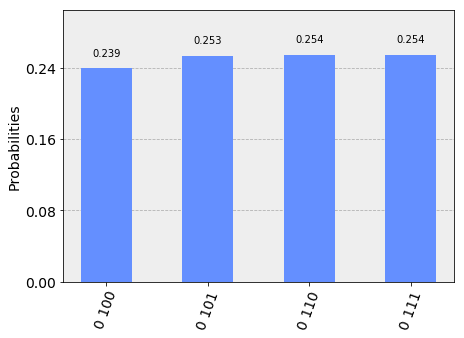

In [27]:
result = ibmsim(qwc)
plot_histogram(result)

## Results
This is the example of whole iteration. The size of each node represents probability of existing quantum walker. 

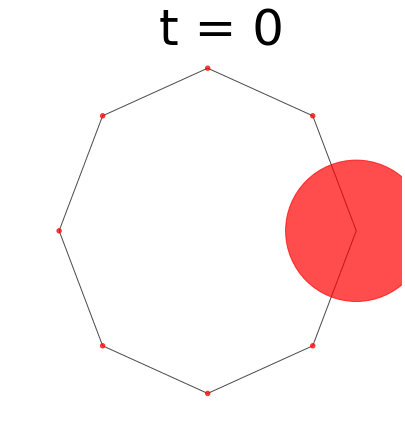

In [28]:
from IPython.display import Image
Image(filename="./fast.gif")

## Required Resources
In this  algorithm, we need $n+1$ qubits for a cycle graph with $2^n$ nodes. As you can see in the circuit, time complexity increases linearly. We take $7$ data points of steps($1, 10, 20, 30, 40, 50, 100$). This is the result of relation between execution time on 'qasm_simulator' and the number of steps.

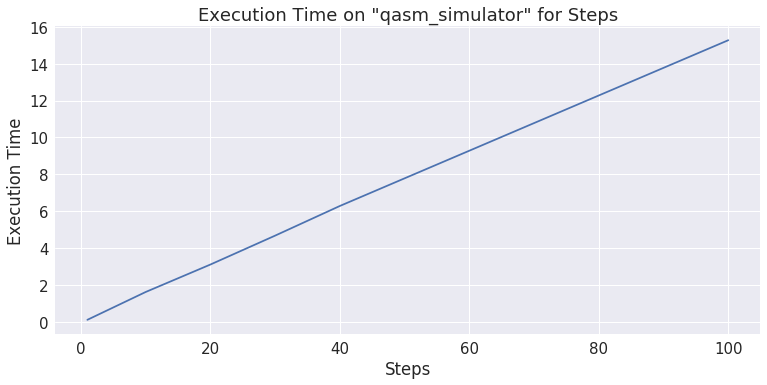

In [1]:
from PIL import Image
path_time = "./exec_graph.png"
display(Image.open(path_time))


32 qubits 2^31 nodes ← cost time....(execution) 
Limitations 

## Discussion about Future Work and Applications

_Many particle quantum random walk_

Simulation evolution of spatial entanglement in many-body physics problems. The graph is a 1D lattice with a particle on each node as initial state. Each particle has separate position and coin hilbert space H = (Hc ⊗ Hp)⊗M. The particles independantly evolve and don't interact. 3-particle system graph are easily implemented in quantum walk but more particles increase number of steps in quantum walk and measurement of entanglement become difficult. More efficient methods of quantum walk implementation will help increase the number of particle systems studied in evolution.  

_Expansion of number of nodes on graph_ 

The graph implemented in this project is 3 qubits for 8 nodes and 1 qubit for coin operation. In total only 4 qubits are used for evolution. The total time for iterating through coin and shift operator is 16 seconds for 100 flips. 
We look at a real world problem that can be applied in quantum random walk on graphs with more nodes. Mapping enzymes as nodes on a graph to understand their evolution when in contact with mutagens only requires 33 nodes which can be mapped out on 7 qubit circuit. This will increase total time to 49 seconds for 100 flips. This is a scalable model which can continue to grow to map more complex graphs to problems. 

Time complexity for  classcal computer (QC-simulator) get approximately $({\frac{m+1}{n+1}})^2$ if the number of nodes becomes $2^m$ from $2^n$. This value is based on number of qubits and roughly estimated. 

#### Expansion for more useful graphs

The cycle graph represents a simple, linear memory architecture (ie. a string). More complicated graph structures, such as binary trees, require higher dimensional "Grover" coins. Such coins are n dimensional bits for graphs of n  The paper [1] presents a generalized form for the grover coin $(G_d)_{i,j}=\frac{2}{d}-\delta_{i,j}$, as well as a circuit for stitched tree of degree 4 that utilizes the Grover coin and the increment and decrement operators we previously defined. A Grover coin of rank $d$ acts on $d-1$ bit state. 


## Conclusion
In this notebook we showed the basics of Quantum Walk and implementation on Quantum Circuit.
This algorithm requires $n+1$ qubits for any cycle graph with $2^n$ nodes.

[1] https://arxiv.org/pdf/0706.0304.pdf

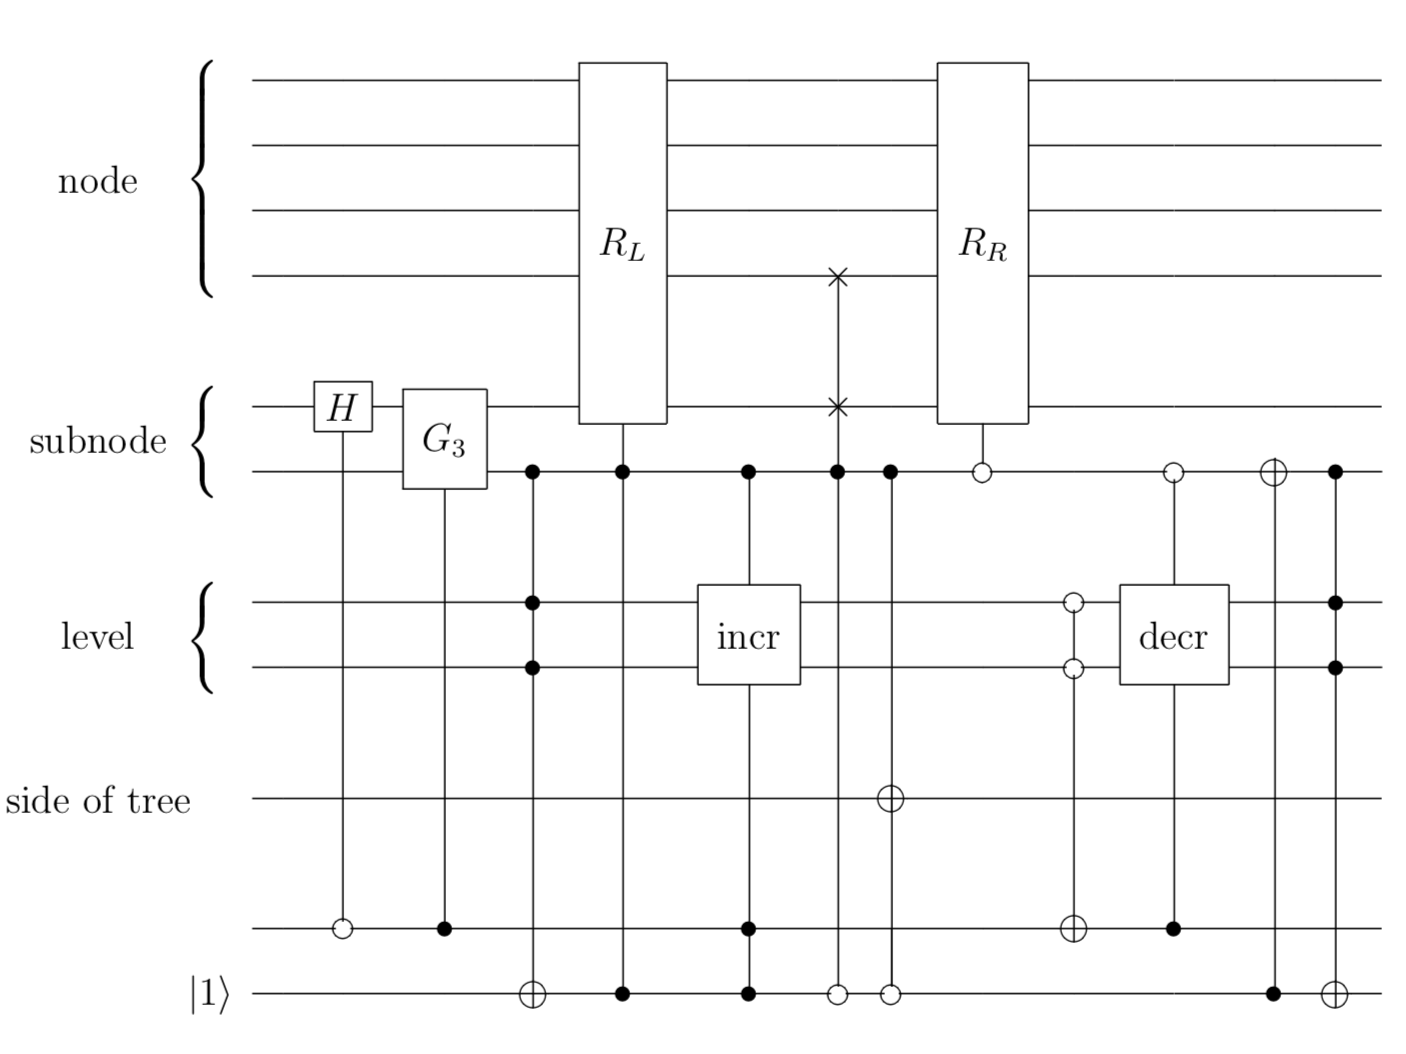

In [6]:
display(Image.open("stcircuit.png"))

Figure 1. The quantum circuit for an $n=4$ stitched tree 